<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/Deep%20Convolutional%20Generative%20Adversarial%20Nets/DCGAN_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import os, time  
from glob import glob
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose, ReLU
from tensorflow.keras import Model

In [ ]:
noise_dim = 100
batch_size = 128
epochs = 70

# Load Celeb_a Dataset

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/content/img_align_celeba/img_align_celeba', label_mode=None, batch_size=batch_size, image_size=(64, 64))
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 202599 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


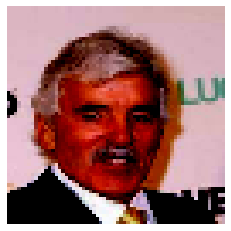

In [ ]:
for x in train_dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Define Generator & Dicriminator

In [ ]:
generator = tf.keras.Sequential([
    Input(shape=(1, 1, noise_dim)),
    Conv2DTranspose(512, kernel_size=4, strides=4, padding="same"),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh'),        
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                        

In [ ]:
discriminator = tf.keras.Sequential([
        Input(shape=(64, 64, 3)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),

        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(256, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(512, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(1, kernel_size=4, strides=2, padding="valid", activation='sigmoid'),       
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                      

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Define Train Function

In [ ]:
@tf.function
def train_step(epoch, images, loss_fn, g_optimizer, d_optimizer):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        noise = tf.random.normal([batch_size, 1, 1, noise_dim], 0, 1)
        g_images = generator(noise, training=True)

        real_out = discriminator(images)
        fake_out = discriminator(g_images)

        g_loss = loss_fn(tf.ones_like(fake_out), fake_out)

        real_loss = loss_fn(tf.ones_like(real_out), real_out)
        fake_loss = loss_fn(tf.zeros_like(fake_out), fake_out)

        d_loss = (real_loss + fake_loss) / 2

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    return g_loss, d_loss

# Training

In [ ]:
for epoch in range(1, 1 + epochs):
    for images in train_dataset:
        g_loss, d_loss = train_step(epoch, images, loss_fn, g_optimizer, d_optimizer)
    print(f'[Epoch {epoch} / {epochs}], G Loss: {g_loss}, D Loss: {d_loss}')

[Epoch 1 / 70], G Loss: 1.3754829168319702, D Loss: 0.3092327117919922
[Epoch 2 / 70], G Loss: 1.5059163570404053, D Loss: 0.33924344182014465
[Epoch 3 / 70], G Loss: 3.2028441429138184, D Loss: 0.32569217681884766
[Epoch 4 / 70], G Loss: 3.0984857082366943, D Loss: 0.40606898069381714
[Epoch 5 / 70], G Loss: 2.415736198425293, D Loss: 0.29197490215301514
[Epoch 6 / 70], G Loss: 1.2944071292877197, D Loss: 0.3875977396965027
[Epoch 7 / 70], G Loss: 1.4501806497573853, D Loss: 0.32861876487731934
[Epoch 8 / 70], G Loss: 1.3941824436187744, D Loss: 0.4306378662586212
[Epoch 9 / 70], G Loss: 1.589553713798523, D Loss: 0.3420359790325165
[Epoch 10 / 70], G Loss: 1.6278530359268188, D Loss: 0.30996018648147583
[Epoch 11 / 70], G Loss: 0.916510820388794, D Loss: 0.6356993913650513
[Epoch 12 / 70], G Loss: 1.2797627449035645, D Loss: 0.37479040026664734
[Epoch 13 / 70], G Loss: 1.670211672782898, D Loss: 0.3333749771118164
[Epoch 14 / 70], G Loss: 1.860151767730713, D Loss: 0.4564562737941742

# Visualization Generated Images

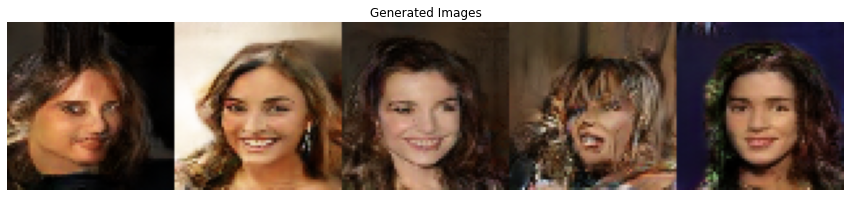

In [ ]:
noise = tf.random.normal([5, 1, 1, noise_dim])

generated_imgs = generator.predict(noise)
generated_imgs = ((generated_imgs * 127.5) + 127.5) / 255. 
generated_imgs = generated_imgs.transpose((1, 0, 2, 3)).reshape(64, -1, 3)

plt.figure(figsize=(15, 4))
plt.imshow(generated_imgs)
plt.axis('off')
plt.title('Generated Images')
plt.show()